# Setup - imports & data loading

In [1]:
#Imports
from modules.preamble import *
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve
import json

from modules.PFS import PFS_layer, PFS_CP
from modules.kappa import *
from modules.RNN_utils import *

%matplotlib inline

# Loading the data

In [2]:
#Load the data
df_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/df_train.hdf'))
df_val = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/df_val.hdf'))
df_test = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/df_test.hdf'))

X_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/X_train.hdf')).values
X_val = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/X_val.hdf')).values
X_test = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/X_test.hdf')).values

y_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/y_train.hdf')).values.ravel() #flat
y_val = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/y_val.hdf')).values.ravel()
y_test = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/y_test.hdf')).values.ravel()

instance_weights_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/instance_weights_train.hdf')).values.ravel()

In [3]:
# Adjust sample weight in training w.r.t classes (i.e. multiply by class weight).
class_weights = compute_class_weight('balanced', [0,1], y_train) #Class weights as array
class_weights = {0: class_weights[0], 1: class_weights[1]} #Convert to dictionary

instance_class_weights_train = np.array(
    [sample_weight * class_weights[y] for sample_weight, y in zip(instance_weights_train, y_train)]
)

In [4]:
#Quick checking of data shapes to see if load was correct
print(df_train.shape, df_val.shape, df_test.shape)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
print(instance_weights_train.shape)

(688457, 31) (117419, 31) (118967, 31)
(688457, 26) (117419, 26) (118967, 26)
(688457,) (117419,) (118967,)
(688457,)


# Load the best configurations

In [5]:
with open(os.path.join(data_base_path, 'model_tuning', 'Best-PFS-config.json'), 'r') as f:
    best_pfs_config = json.load(f)

with open(os.path.join(data_base_path, 'model_tuning', 'Best-DNN-configs.json'), 'r') as f:
    best_dnn_configs = json.load(f)
    
with open(os.path.join(data_base_path, 'model_tuning', 'Best-GRU-configs.json'), 'r') as f:
    best_gru_configs = json.load(f)

In [6]:
#Store indices of the best pfs config - we need them multiple times
pfs_feats_indices = best_pfs_config['feature_indices']

# Clustering & PFS-CP fitting

In [7]:
np.random.seed(best_pfs_config['seed'])

km = KMeans(n_clusters = best_pfs_config['n_rules'],
            random_state = best_pfs_config['seed'],
            n_jobs=-1)

km.fit(X_train[:, pfs_feats_indices],
       sample_weight = instance_class_weights_train)

cluster_centers = km.cluster_centers_

C:\Users\KevinReijnders\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [8]:
#Fit the PFS-CP
pfs_cp = PFS_CP(cluster_centers)
pfs_cp.fit(X_train[:, pfs_feats_indices], y_train)

In [9]:
#Preliminary performance assessment on the validation set
y_score_cp = pfs_cp.predict_proba(X_val[:, pfs_feats_indices])[:,1]
print("ROC-AUC on val set:", roc_auc_score(y_val, y_score_cp))
print("AUK on val set:", auk_score(y_val, y_score_cp))

ROC-AUC on val set: 0.6776980996753625
AUK on val set: 0.08170389438367107


# PFS-ML fitting
Fit the PFS with gradient descent.

In [13]:
#Setup the PFS with gradient descent
model = tf.keras.Sequential()
model.add(PFS_layer(X_train[:, pfs_feats_indices],
                    y_train,
                    cluster_centers))
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(curve='ROC', name='ROC_AUC')]) 

# Fit the PFS with gradient descent
model.fit(X_train[:, pfs_feats_indices],
          y_train,
          sample_weight = instance_class_weights_train, #custom approach to include class weights here
          validation_data=(X_val[:,pfs_feats_indices], y_val),
          epochs=100,
          batch_size=512,
          callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_ROC_AUC',
                                                       mode='max',
                                                       patience=5, 
                                                       min_delta=0.005)])

Epoch 1/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0045 - ROC_AUC: 0.5289 - val_loss: 0.4891 - val_ROC_AUC: 0.6272
Epoch 2/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0027 - ROC_AUC: 0.5079 - val_loss: 0.8132 - val_ROC_AUC: 0.6641
Epoch 3/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0021 - ROC_AUC: 0.6931 - val_loss: 0.9226 - val_ROC_AUC: 0.6954
Epoch 4/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0020 - ROC_AUC: 0.7180 - val_loss: 0.9605 - val_ROC_AUC: 0.6976
Epoch 5/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0019 - ROC_AUC: 0.7291 - val_loss: 0.9863 - val_ROC_AUC: 0.7031
Epoch 6/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0019 - ROC_AUC: 0.7331 - val_loss: 0.9751 - val_ROC_AUC: 0.7076
Epoch 7/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0019 - ROC_AUC: 0.7330 - val_loss: 1.0000 - val_ROC_AUC: 0.7101

In [14]:
#Load the parameters in the numpy-version of the PFS for better performance, i.e. faster inference during bootstrapping
centers, widths, cond_probs = model.layers[0].get_parameters()

pfs_ml = PFS_CP(centers) #We'll set the parameters found by ML
pfs_ml.widths_ = widths
pfs_ml.cond_probs_ = cond_probs

In [15]:
#Preliminary performance assessment on the validation set
y_score_pfs_ml = pfs_ml.predict_proba(X_val[:, pfs_feats_indices])[:,1]
print("ROC-AUC on val set:", roc_auc_score(y_val, y_score_pfs_ml))
print("AUK on val set:", auk_score(y_val, y_score_pfs_ml))

ROC-AUC on val set: 0.7126814092738978
AUK on val set: 0.10280558965643483


In [18]:
#Pickle the two models for convenient retrieval in other notebooks
# pickle.dump(pfs_cp, 
#             open(os.path.join(data_base_path, 'final_models', 'pfs_cp.pickle'), 'wb')
#            )
# pickle.dump(pfs_ml,
#             open(os.path.join(data_base_path, 'final_models', 'pfs_ml.pickle'), 'wb')
#            )

# Densely Connected Neural Networks

## Fitting model with all features

In [8]:
#Build the DNN for all features in the data
dnn_all_feats = tf.keras.Sequential()
dnn_all_feats.add(tf.keras.layers.Dense(best_dnn_configs['1']['n_units_per_layer'][0],
                                activation='relu',
                                input_shape=(X_train.shape[1],)))

for i in range(1, best_dnn_configs['1']['n_layers']):
        dnn_all_feats.add(tf.keras.layers.Dropout(best_dnn_configs['1']['dropout_rates'][i-1]))
        dnn_all_feats.add(tf.keras.layers.Dense(best_dnn_configs['1']['n_units_per_layer'][i]))
        
dnn_all_feats.add(tf.keras.layers.Dense(1, activation='sigmoid'))
dnn_all_feats.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(curve='ROC', name='ROC_AUC')])
dnn_all_feats.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 35)                945       
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 77)                2772      
_________________________________________________________________
dropout_1 (Dropout)          (None, 77)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 221)               17238     
_________________________________________________________________
dropout_2 (Dropout)          (None, 221)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 417)               9

In [9]:
dnn_all_feats.fit(X_train,
                  y_train,
                  sample_weight = instance_class_weights_train,
                  validation_data=(X_val, y_val),
                  epochs=100,
                  batch_size=512,
                  callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_ROC_AUC',
                                                               mode='max',
                                                               patience=5, 
                                                               min_delta=0.005)])

Epoch 1/100
1345/1345 [==============================] - 12s 9ms/step - loss: 0.0016 - ROC_AUC: 0.7735 - val_loss: 0.8250 - val_ROC_AUC: 0.7900
Epoch 2/100
1345/1345 [==============================] - 12s 9ms/step - loss: 0.0015 - ROC_AUC: 0.7998 - val_loss: 0.8091 - val_ROC_AUC: 0.7919
Epoch 3/100
1345/1345 [==============================] - 13s 10ms/step - loss: 0.0015 - ROC_AUC: 0.8084 - val_loss: 0.7362 - val_ROC_AUC: 0.7895
Epoch 4/100
1345/1345 [==============================] - 12s 9ms/step - loss: 0.0015 - ROC_AUC: 0.8116 - val_loss: 0.7666 - val_ROC_AUC: 0.7907
Epoch 5/100
1345/1345 [==============================] - 12s 9ms/step - loss: 0.0015 - ROC_AUC: 0.8120 - val_loss: 0.7833 - val_ROC_AUC: 0.7883
Epoch 6/100
1345/1345 [==============================] - 12s 9ms/step - loss: 0.0014 - ROC_AUC: 0.8133 - val_loss: 0.7785 - val_ROC_AUC: 0.7902


In [10]:
dnn_all_feats.evaluate(X_val, y_val)

3670/3670 [==============================] - 4s 1ms/step - loss: 0.7785 - ROC_AUC: 0.7902


[0.7785313129425049, 0.7901966571807861]

## Fitting model with features from the best PFS

In [15]:
#Build the model for the pfs features in the data. Only 1 layer, so simpler than previous model
dnn_pfs_feats = tf.keras.Sequential()

dnn_pfs_feats.add(tf.keras.layers.Dense(best_dnn_configs['2']['n_units_per_layer'][0],
                                        activation='relu',
                                        input_shape=(len(pfs_feats_indices),))
                 )
        
dnn_pfs_feats.add(tf.keras.layers.Dense(1, activation='sigmoid'))

dnn_pfs_feats.compile(optimizer='Adam',
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.AUC(curve='ROC', name='ROC_AUC')])

dnn_pfs_feats.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 127)               1016      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 128       
Total params: 1,144
Trainable params: 1,144
Non-trainable params: 0
_________________________________________________________________


In [16]:
dnn_pfs_feats.fit(X_train[:, pfs_feats_indices],
                  y_train,
                  sample_weight = instance_class_weights_train,
                  validation_data=(X_val[:, pfs_feats_indices], y_val),
                  epochs=100,
                  batch_size=512,
                  callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_ROC_AUC',
                                                               mode='max',
                                                               patience=5, 
                                                               min_delta=0.005)])

Epoch 1/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0019 - ROC_AUC: 0.7415 - val_loss: 0.9656 - val_ROC_AUC: 0.7106
Epoch 2/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0018 - ROC_AUC: 0.7547 - val_loss: 0.9463 - val_ROC_AUC: 0.7105
Epoch 3/100
1345/1345 [==============================] - 2s 2ms/step - loss: 0.0018 - ROC_AUC: 0.7581 - val_loss: 0.9111 - val_ROC_AUC: 0.7014
Epoch 4/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0018 - ROC_AUC: 0.7576 - val_loss: 0.8791 - val_ROC_AUC: 0.7058
Epoch 5/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0018 - ROC_AUC: 0.7575 - val_loss: 0.8849 - val_ROC_AUC: 0.7043
Epoch 6/100
1345/1345 [==============================] - 3s 2ms/step - loss: 0.0018 - ROC_AUC: 0.7579 - val_loss: 0.9508 - val_ROC_AUC: 0.7047


In [17]:
dnn_pfs_feats.evaluate(X_val[:, pfs_feats_indices], y_val) #Slightly lower than previously, because we did not set random seed here probably

3670/3670 [==============================] - 3s 751us/step - loss: 0.9508 - ROC_AUC: 0.7047


[0.950806736946106, 0.7047449350357056]

In [18]:
#Store the two models for convenient retrieving
dnn_all_feats.save(os.path.join(data_base_path, 'final_models', 'dnn_all_feats'))
dnn_pfs_feats.save(os.path.join(data_base_path, 'final_models', 'dnn_pfs_feats'))

# GRU networks

## Fitting model with all features

In [7]:
#Convert the data to sequence format (shape: (n_patients, n_observations, n_features))
X_seq_train, y_seq_train, instance_class_weights_seq_train = to_seq(df_train,
                                                                    'subject_id',
                                                                     X_train,
                                                                     y_train,
                                                                     instance_class_weights_train)

X_seq_val, y_seq_val = to_seq(df_val,
                              'subject_id',
                               X_val,
                               y_val)                                                                   

X_seq_test, y_seq_test = to_seq(df_test,
                              'subject_id',
                               X_test,
                               y_test) 

#Brief check: inspect some shapes of arrays
print(len(X_seq_train), len(X_seq_val), len(X_seq_test))
print(len(instance_class_weights_seq_train))
print(len(y_seq_train), len(y_seq_val), len(y_seq_test))
print(X_seq_test[100].shape)

1691 362 363
1691
1691 362 363
(322, 26)


In [8]:
#Build the GRU for all features in the data - just 1 GRU layer in this configuration
gru_all_feats = tf.keras.Sequential()
gru_all_feats.add(tf.keras.layers.GRU(best_gru_configs['1']['n_units_per_layer'][0],
                                      input_shape = (None, X_train.shape[1]),
                                      return_sequences = True)
                 )
        
gru_all_feats.add(tf.keras.layers.Dense(1, activation='sigmoid')) #output layer

gru_all_feats.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(curve='ROC', name='ROC_AUC')])

gru_all_feats.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 16)          2112      
_________________________________________________________________
dense (Dense)                (None, None, 1)           17        
Total params: 2,129
Trainable params: 2,129
Non-trainable params: 0
_________________________________________________________________


In [9]:
#Use a batch size of 1 to avoid excessive zero-padding and an excessive amount of extra data points to fit the model to
train_gen = Sequence_generator(X_seq_train, y_seq_train, batch_size=1, sample_weight=instance_class_weights_seq_train)
val_gen = Sequence_generator(X_seq_val, y_seq_val, batch_size=1)

gru_all_feats.fit(train_gen,
                  validation_data=val_gen,
                  epochs=100,
                  verbose=1,
                  callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_ROC_AUC',
                                                               mode='max',
                                                               patience=1, 
                                                               min_delta=0.05)]) #Stricter early stopping criteria because more expensive model

Epoch 1/100
1691/1691 [==============================] - 311s 184ms/step - loss: 0.0063 - ROC_AUC: 0.7262 - val_loss: 0.7449 - val_ROC_AUC: 0.7705
Epoch 2/100
1691/1691 [==============================] - 295s 174ms/step - loss: 0.0046 - ROC_AUC: 0.7617 - val_loss: 0.7290 - val_ROC_AUC: 0.7837


In [10]:
#Compute preliminary performance using the workaround from the GRU notebook
val_gen = Sequence_generator(X_seq_val, batch_size=len(X_seq_val)) #Create generator
y_score_seq = gru_all_feats.predict(val_gen) #Predict for all (padded) sequences
seq_lengths = [X_seq_val[i].shape[0] for i in range(len(X_seq_val))] #Prune the padding
y_score = np.vstack([y_score_seq[i][:seq_lengths[i]] for i in range(y_score_seq.shape[0])]) #Flatten the labels again
roc_auc = roc_auc_score(y_val, y_score)
roc_auc

0.7837348328209149

This matches roughly wat we found earlier during the tuning.

## Fitting model with features from the best PFS

In [8]:
#Alter sequences such that they only have the features selected in the PFS
X_seq_new = []
for X_seq in X_seq_train:
    X_seq_new.append(
        X_seq[:,pfs_feats_indices]
    )
X_seq_train_pfs_feats = np.array(X_seq_new)

X_seq_new = []
for X_seq in X_seq_val:
    X_seq_new.append(
        X_seq[:,pfs_feats_indices]
    )
X_seq_val_pfs_feats = np.array(X_seq_new)

X_seq_new = []
for X_seq in X_seq_test:
    X_seq_new.append(
        X_seq[:,pfs_feats_indices]
    )
X_seq_test_pfs_feats = np.array(X_seq_new)

In [9]:
best_gru_configs

{'1': {'features': 'all',
  'n_layers': 1,
  'n_units_per_layer': [16],
  'dropout_rates': []},
 '2': {'features': 'best_pfs',
  'n_layers': 2,
  'n_units_per_layer': [2, 15],
  'dropout_rates': [0.034833486428848]}}

In [17]:
#Build the GRU for all features in the data
gru_pfs_feats = tf.keras.Sequential()
gru_pfs_feats.add(tf.keras.layers.GRU(best_gru_configs['2']['n_units_per_layer'][0],
                                      input_shape = (None, len(pfs_feats_indices)),
                                      return_sequences = True)
                 )
gru_pfs_feats.add(tf.keras.layers.GRU(best_gru_configs['2']['n_units_per_layer'][1],
                                      dropout = best_gru_configs['2']['dropout_rates'][0],
                                      return_sequences = True)
                 )
        
gru_pfs_feats.add(tf.keras.layers.Dense(1, activation='sigmoid')) #output layer

gru_pfs_feats.compile(optimizer='Adam',
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.AUC(curve='ROC', name='ROC_AUC')])

gru_pfs_feats.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 2)           66        
_________________________________________________________________
gru_2 (GRU)                  (None, None, 15)          855       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           16        
Total params: 937
Trainable params: 937
Non-trainable params: 0
_________________________________________________________________


In [18]:
#Use a batch size of 1 to avoid excessive zero-padding and an excessive amount of extra data points to fit the model to
train_gen = Sequence_generator(X_seq_train_pfs_feats, 
                               y_seq_train,
                               batch_size=1, 
                               sample_weight=instance_class_weights_seq_train)

val_gen = Sequence_generator(X_seq_val_pfs_feats, 
                             y_seq_val,
                             batch_size=1)

gru_pfs_feats.fit(train_gen,
                  validation_data=val_gen,
                  epochs=100,
                  verbose=1,
                  callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_ROC_AUC',
                                                               mode='max',
                                                               patience=1, 
                                                               min_delta=0.05)]) #Stricter early stopping criteria because more expensive model

Epoch 1/100
1691/1691 [==============================] - 791s 468ms/step - loss: 0.0082 - ROC_AUC: 0.6664 - val_loss: 1.0412 - val_ROC_AUC: 0.6805
Epoch 2/100
1691/1691 [==============================] - 747s 442ms/step - loss: 0.0072 - ROC_AUC: 0.7014 - val_loss: 1.1994 - val_ROC_AUC: 0.6788


In [19]:
#Compute preliminary performance using the workaround from the GRU notebook
val_gen = Sequence_generator(X_seq_val_pfs_feats, batch_size=len(X_seq_val_pfs_feats)) #Create generator
y_score_seq = gru_pfs_feats.predict(val_gen) #Predict for all (padded) sequences
seq_lengths = [X_seq_val_pfs_feats[i].shape[0] for i in range(len(X_seq_val_pfs_feats))] #Prune the padding
y_score = np.vstack([y_score_seq[i][:seq_lengths[i]] for i in range(y_score_seq.shape[0])]) #Flatten the labels again
roc_auc = roc_auc_score(y_val, y_score)
roc_auc

0.6801292074486481

In [20]:
#Store the two models for convenient retrieving without having to re-fit the models again
gru_all_feats.save(os.path.join(data_base_path, 'final_models', 'gru_all_feats'))
gru_pfs_feats.save(os.path.join(data_base_path, 'final_models', 'gru_pfs_feats'))

W0529 12:47:17.117398  7136 deprecation.py:506] From C:\Users\KevinReijnders\Anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Final evaluation with bootstrapping

In [9]:
#Load the 6 models from memory
pfs_cp = pickle.load(open(os.path.join(data_base_path, 'final_models', 'pfs_cp.pickle'),
                          'rb'))
pfs_ml = pickle.load(open(os.path.join(data_base_path, 'final_models', 'pfs_ml.pickle'),
                          'rb'))

dnn_all_feats = tf.keras.models.load_model(os.path.join(data_base_path, 'final_models', 'dnn_all_feats'))
dnn_pfs_feats = tf.keras.models.load_model(os.path.join(data_base_path, 'final_models', 'dnn_pfs_feats'))

gru_all_feats = tf.keras.models.load_model(os.path.join(data_base_path, 'final_models', 'gru_all_feats'))
gru_pfs_feats = tf.keras.models.load_model(os.path.join(data_base_path, 'final_models', 'gru_pfs_feats'))

all_models = [pfs_cp, pfs_ml, dnn_all_feats, dnn_pfs_feats, gru_all_feats, gru_pfs_feats]

In [10]:
df_test

,subject_id,charttime,arterial base excess,arterial pco2,arterial ph,arterial po2,bicarbonate,bilirubin,calcium,creatinine,crp,cvp,diastolic blood pressure,fio2,glucose,got(asat),gpt(alat),heart rate,hematocrit,platelets,potassium,ptt,sodium,spo2,systolic blood pressure,temperature,urea,white blood cells,deathtime,time to death,y
0,112,2196-09-27 13:30:00,NaN,NaN,NaN,NaN,30.000000,NaN,NaN,2.4,NaN,NaN,NaN,NaN,84.000000,NaN,NaN,NaN,25.400000,265.000000,4.600000,33.500000,125.000000,NaN,NaN,NaN,43.000000,11.000000,2196-09-29 00:15:00,1 days 10:45:00,1
1,112,2196-09-27 13:45:00,NaN,NaN,NaN,NaN,30.000000,NaN,NaN,2.4,NaN,NaN,NaN,NaN,84.000000,NaN,NaN,NaN,25.400000,265.000000,4.700000,33.500000,125.000000,NaN,NaN,NaN,43.000000,11.000000,2196-09-29 00:15:00,1 days 10:30:00,1
2,112,2196-09-27 14:20:00,7.0,39.0,7.51,123.00,30.000000,NaN,NaN,2.4,NaN,NaN,NaN,NaN,84.000000,NaN,NaN,NaN,25.400000,265.000000,4.700000,33.500000,125.000000,NaN,NaN,NaN,43.000000,11.000000,2196-09-29 00:15:00,1 days 09:55:00,1
3,112,2196-09-27 20:30:00,7.0,39.0,7.51,123.00,30.000000,NaN,7.600000,2.4,NaN,NaN,NaN,NaN,84.000000,NaN,NaN,NaN,25.400000,265.000000,4.700000,33.500000,125.000000,NaN,NaN,NaN,43.000000,11.000000,2196-09-29 00:15:00,1 days 03:45:00,1
4,112,2196-09-27 22:25:00,5.5,34.5,7.51,166.75,30.000000,NaN,7.600000,2.4,NaN,NaN,NaN,NaN,84.000000,NaN,NaN,NaN,25.400000,265.000000,4.700000,33.500000,125.000000,NaN,NaN,NaN,43.000000,11.000000,2196-09-29 00:15:00,1 days 01:50:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118962,99985,2181-02-09 10:00:00,0.0,31.0,7.48,74.00,23.000000,0.50,8.200000,1.0,NaN,NaN,67.0,50.0,113.000000,41.000000,51.000000,101.25,25.300000,948.000000,4.200000,37.300000,136.000000,95.0,130.0,37.111111,17.000000,20.400000,NaT,NaT,0
118963,99985,2181-02-09 11:00:00,0.0,31.0,7.48,74.00,23.000000,0.50,8.200000,1.0,NaN,NaN,64.5,50.0,113.000000,41.000000,51.000000,98.00,25.300000,948.000000,4.200000,37.300000,136.000000,98.0,131.0,37.111111,17.000000,20.400000,NaT,NaT,0
118964,99985,2181-02-10 07:28:00,0.0,31.0,7.48,74.00,25.785714,0.55,8.200000,0.9,NaN,NaN,66.0,50.0,107.000000,40.428571,50.714286,97.00,28.514286,927.428571,4.092857,48.214286,136.000000,98.0,133.0,37.111111,13.857143,18.614286,NaT,NaT,0
118965,99985,2181-02-11 05:35:00,0.0,31.0,7.48,74.00,26.928571,0.55,8.228571,0.9,NaN,NaN,66.0,50.0,113.714286,36.285714,46.714286,97.00,28.442857,844.000000,3.678571,44.342857,137.714286,98.0,133.0,37.111111,13.000000,14.650000,NaT,NaT,0


In [11]:
#Generate mapping from index in df_test to sequence index and timestep index in X_seq_test
#Required for efficient retrieval of the sequences in the bootstrapping procedure
subj_id_to_index_nr = {subj_id:i for i, subj_id in enumerate(df_test['subject_id'].unique())} #Retrieve the index nr of each subject_id in the X_test_seq
index_seq_nr_timestep_nr = df_test['subject_id'].map(subj_id_to_index_nr).to_frame('subj_index')
index_seq_nr_timestep_nr['timestep_index'] = 1
index_seq_nr_timestep_nr['timestep_index'] = index_seq_nr_timestep_nr.groupby('subj_index').transform('cumsum')

In [12]:
#Quick checks if the mapping is correct
index_seq_nr_timestep_nr.groupby('subj_index').agg(['min', 'max'])

timestep_index      
                      min   max
subj_index                     
0                       1    61
1                       1    36
2                       1   136
3                       1   471
4                       1    97
...                   ...   ...
358                     1   130
359                     1  1756
360                     1    15
361                     1   381
362                     1   346

[363 rows x 2 columns]

In [15]:
len(X_seq_test[0]), len(X_seq_test[1]), len(X_seq_test[-1])

(61, 36, 346)

Seems to be correct! Indexing starts at 1 and ends at the length of the sequence for our purpose (each time, we want to select the beginning of the sequence until the timestep_index).

In [ ]:
#Runs for approximately 1 hour
np.random.seed(50) #For reproducibility

start = time.time()
scores = []

for i in range(500):
    #Progress printing
    if (i%25 == 0):
        print("Processing iteration:", i, '--- Minutes since start:', (time.time() - start)/60)
        
    #Select which indices of the original test data that we will use in this bootstrap
    sel_indices = np.random.choice(df_test.index.values, 1000, replace=True)

    #Compose the features & labels of the bootstrapped dataset for predicting with the PFSs & DNNs
    X_test_bootstrap = X_test[sel_indices, :] 
    y_test_bootstrap = y_test[sel_indices]
    
    #Compose the features & labels of the bootstrapped dataset for predicting with the GRUs
    X_seq_test_allfeats_bootstrap = []
    X_seq_test_pfsfeats_bootstrap = []

    for sel_index in sel_indices:
        #Retrieve corresponding subject & timestep index
        subj_index = index_seq_nr_timestep_nr.loc[sel_index, 'subj_index']
        timestep_index = index_seq_nr_timestep_nr.loc[sel_index, 'timestep_index']

        #Append the sequence of this particular subject until the particular timestep
        X_seq_test_allfeats_bootstrap.append(
            X_seq_test[subj_index][:timestep_index]
        )
        X_seq_test_pfsfeats_bootstrap.append(
            X_seq_test[subj_index][:timestep_index, pfs_feats_indices]
        )

    X_seq_test_allfeats_bootstrap = np.array(X_seq_test_allfeats_bootstrap)
    X_seq_test_pfsfeats_bootstrap = np.array(X_seq_test_pfsfeats_bootstrap)
    
    #Generators for predicting with the GRUs
    test_gen_allfeats_bootstrap = Sequence_generator(X_seq_test_allfeats_bootstrap,
                                                     batch_size=len(X_seq_test_allfeats_bootstrap))
    test_gen_pfsfeats_bootstrap = Sequence_generator(X_seq_test_pfsfeats_bootstrap,
                                                     batch_size=len(X_seq_test_pfsfeats_bootstrap))

    #Asses AUC-ROC & PR-ROC for each model and store the results
    model_scores = []
    for j, model in enumerate(all_models):
        if (j <= 1): #Then we have a PFS
            y_score_bootstrap = model.predict_proba(X_test_bootstrap[:, pfs_feats_indices])[:,1].flatten()
        elif (j==2): #Then we have a DNN with all features
            y_score_bootstrap = model.predict(X_test_bootstrap).flatten()
        elif (j==3): #Then we have the DNN with the PFS features
            y_score_bootstrap = model.predict(X_test_bootstrap[:, pfs_feats_indices]).flatten()
        elif (j==4): #Then we have the GRU with all features, and must predict with the workaround
            y_score_seq = model.predict(test_gen_allfeats_bootstrap) #Predict for all (padded) sequences
            seq_lengths = [X_seq_test_allfeats_bootstrap[i].shape[0] for i in range(len(X_seq_test_allfeats_bootstrap))] #Prune the padding
            y_score_bootstrap = np.vstack([y_score_seq[i][seq_lengths[i]-1] for i in range(y_score_seq.shape[0])]) #Flatten the labels again
        else: #Then we have the GRU with the PFS features, and must predict with the workaround
            y_score_seq = model.predict(test_gen_pfsfeats_bootstrap) #Predict for all (padded) sequences
            seq_lengths = [X_seq_test_pfsfeats_bootstrap[i].shape[0] for i in range(len(X_seq_test_pfsfeats_bootstrap))] #Prune the padding
            y_score_bootstrap = np.vstack([y_score_seq[i][seq_lengths[i]-1] for i in range(y_score_seq.shape[0])]) #Flatten the labels again
            
        #Compute metrics for the current model
        roc_auc = roc_auc_score(y_test_bootstrap, y_score_bootstrap)
        auk = auk_score(y_test_bootstrap, y_score_bootstrap)
        model_scores.extend([roc_auc, auk])
    
    #Store the results outside the loop
    scores.append(model_scores)

In [10]:
#Store results on disk
# colnames = ['PFS_CP - ROC-AUC', 'PFS_CP - AUK', 'PFS_ML - ROC-AUC', 'PFS_ML - AUK',
#             'DNN_ALL - ROC-AUC', 'DNN_ALL - AUK', 'DNN_PFS - ROC-AUC', 'DNN_PFS - AUK', 
#             'GRU_ALL - ROC-AUC', 'GRU_ALL - AUK', 'GRU_PFS - ROC-AUC', 'GRU_PFS - AUK']
# df_res = pd.DataFrame(scores, columns=colnames)
# df_res.to_excel(os.path.join(data_base_path, 'bootstrapping-results-all-models.xlsx'))

In [12]:
#Retrieve results from disk for persistence without having to re-run the expensive computation
df_res = pd.read_excel(os.path.join(data_base_path, 'bootstrapping-results-all-models.xlsx'), 
                       index_col=0)

In [13]:
df_res.head()

,PFS_CP - ROC-AUC,PFS_CP - AUK,PFS_ML - ROC-AUC,PFS_ML - AUK,DNN_ALL - ROC-AUC,DNN_ALL - AUK,DNN_PFS - ROC-AUC,DNN_PFS - AUK,GRU_ALL - ROC-AUC,GRU_ALL - AUK,GRU_PFS - ROC-AUC,GRU_PFS - AUK
0,0.587057,0.033916,0.620096,0.052060,0.741502,0.107057,0.684978,0.079495,0.707967,0.088443,0.575149,0.031390
1,0.624459,0.051393,0.630556,0.061505,0.736206,0.117032,0.635271,0.066982,0.721764,0.105577,0.636310,0.062187
2,0.614437,0.060576,0.640755,0.077523,0.727249,0.121412,0.653217,0.083679,0.730509,0.116895,0.611139,0.059499
3,0.663187,0.072427,0.695293,0.094006,0.797285,0.142341,0.696538,0.095474,0.774672,0.131372,0.651851,0.070567
4,0.664555,0.078854,0.700757,0.097183,0.806887,0.147122,0.738923,0.118499,0.752783,0.119580,0.678163,0.087182


In [14]:
#Overview with the means & stds of the scores
auk_means = df_res.iloc[:, [1,3,5,7,9,11]].mean().values
auk_stds = df_res.iloc[:, [1,3,5,7,9,11]].std().values

rocauc_means = df_res.iloc[:, [0,2,4,6,8,10]].mean().values
rocauc_stds = df_res.iloc[:, [0,2,4,6,8,10]].std().values

rocaucs = ['{:.4f} ({:.4f})'.format(roc_auc, auk) for roc_auc, auk in zip(rocauc_means, rocauc_stds)]
auks = ['{:.4f} ({:.4f})'.format(roc_auc, auk) for roc_auc, auk in zip(auk_means, auk_stds)]

modelnames = ['PFS-CP', 'PFS-ML', 'DNN (all features)', 'DNN (7 features)', 'GRU (all features)', 'GRU (7 features)']
df_res_summary = pd.DataFrame(np.vstack((rocaucs, auks)), index=['ROC-AUC (std)', 'AUK (std)'], columns=modelnames).T
df_res_summary

,ROC-AUC (std),AUK (std)
PFS-CP,0.6540 (0.0309),0.0714 (0.0150)
PFS-ML,0.6910 (0.0315),0.0937 (0.0156)
DNN (all features),0.7838 (0.0260),0.1394 (0.0152)
DNN (7 features),0.7096 (0.0311),0.1023 (0.0156)
GRU (all features),0.7547 (0.0274),0.1226 (0.0153)
GRU (7 features),0.6505 (0.0320),0.0712 (0.0153)


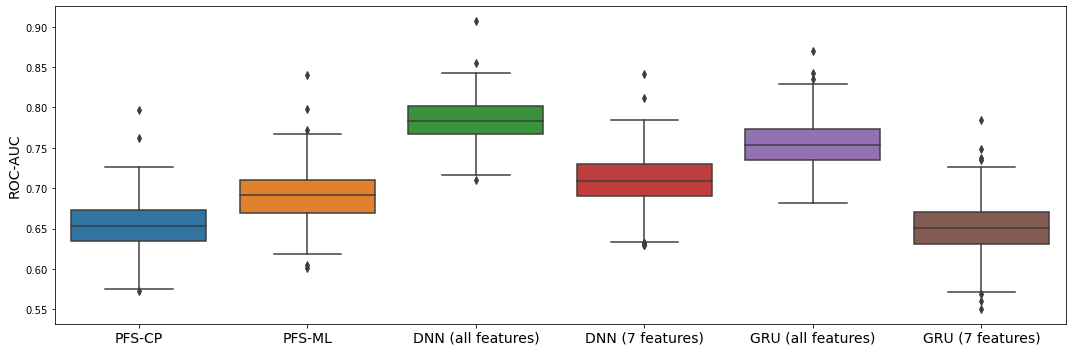

In [12]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.boxplot(x="variable", y="value", data=pd.melt(df_res.iloc[:,[0,2,4,6,8,10]]), ax=ax)
ax.set_xlabel("");
ax.set_ylabel("ROC-AUC", fontsize=14);

ax.xaxis.set_ticks([0,1,2,3,4,5])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_xticklabels(modelnames)

fig.tight_layout()
    
# fig.savefig(os.path.join(figs_base_path, 'quant-eval-boxplots.png'),dpi=200)

In [21]:
from scipy.stats import mannwhitneyu, ttest_ind, ttest_rel
from itertools import combinations

[comb for comb in combinations(df_res.columns[[0,2,4,6,8,10]], 2)]

mwu_stats = []
ttest_stats = []
for colnum1 in [0,2,4,6,8,10]:
    col_vals_mwu = []
    col_vals_tt = []
    for colnum2 in [0,2,4,6,8,10]:
        col_vals_mwu.append(
            mannwhitneyu(df_res.iloc[:,colnum1], df_res.iloc[:,colnum2]).pvalue
        )
        col_vals_tt.append(
            ttest_ind(df_res.iloc[:,colnum1], df_res.iloc[:,colnum2]).pvalue
        )

    mwu_stats.append(col_vals_mwu)
    ttest_stats.append(col_vals_tt)

In [16]:
#Results seem pretty much the same regarding p-values no matter whether we use the ttest or whitenyutest
pd.DataFrame(mwu_stats, columns=modelnames, index=modelnames)

,PFS-CP,PFS-ML,DNN (all features),DNN (7 features),GRU (all features),GRU (7 features)
PFS-CP,4.999563e-01,1.119768e-61,4.979562e-164,1.477655e-106,6.992701e-161,3.679352e-02
PFS-ML,1.119768e-61,4.999563e-01,1.540871e-157,1.084892e-20,1.207210e-128,1.417143e-69
DNN (all features),4.979562e-164,1.540871e-157,4.999563e-01,2.040632e-145,1.108591e-53,2.548128e-164
DNN (7 features),1.477655e-106,1.084892e-20,2.040632e-145,4.999563e-01,7.400885e-90,1.525118e-111
GRU (all features),6.992701e-161,1.207210e-128,1.108591e-53,7.400885e-90,4.999563e-01,1.212551e-160
GRU (7 features),3.679352e-02,1.417143e-69,2.548128e-164,1.525118e-111,1.212551e-160,4.999563e-01


In [22]:
# pd.options.display.float_format = '{:.3f}'.format
pd.DataFrame(ttest_stats, columns=modelnames, index=modelnames)

,PFS-CP,PFS-ML,DNN (all features),DNN (7 features),GRU (all features),GRU (7 features)
PFS-CP,1.000000e+00,1.358729e-67,0.000000e+00,3.095584e-130,8.393739e-302,7.250164e-02
PFS-ML,1.358729e-67,1.000000e+00,4.173529e-279,4.179538e-20,5.566492e-170,1.771293e-76
DNN (all features),0.000000e+00,4.173529e-279,1.000000e+00,8.754440e-216,2.776739e-58,0.000000e+00
DNN (7 features),3.095584e-130,4.179538e-20,8.754440e-216,1.000000e+00,2.771288e-103,5.557991e-139
GRU (all features),8.393739e-302,5.566492e-170,2.776739e-58,2.771288e-103,1.000000e+00,1.792127e-306
GRU (7 features),7.250164e-02,1.771293e-76,0.000000e+00,5.557991e-139,1.792127e-306,1.000000e+00


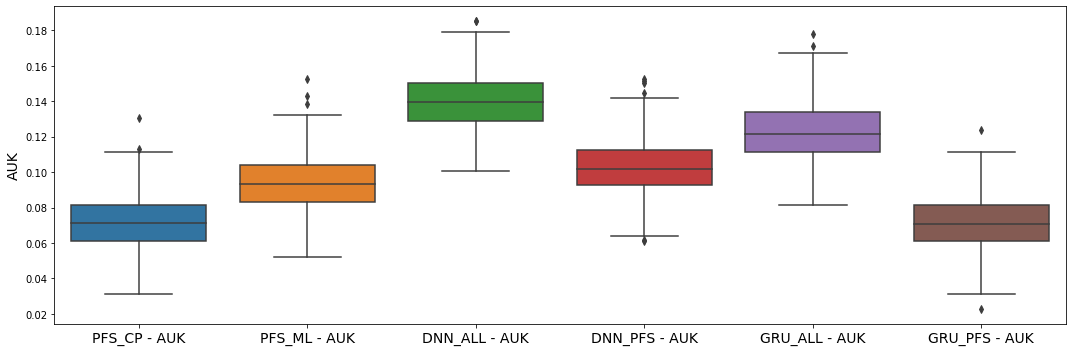

In [23]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.boxplot(x="variable", y="value", data=pd.melt(df_res.iloc[:,[1,3,5,7,9,11]]), ax=ax)
ax.set_xlabel("");
ax.set_ylabel("AUK", fontsize=14);
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
fig.tight_layout()
# ax.set_xticks()

# ROC & Kappa curves on the full test set

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_seq_test_padded = pad_sequences(X_seq_test, dtype='float64', padding='post')
y_seq_test_padded = pad_sequences(y_seq_test, padding='post')

X_seq_test_padded_pfs_feats = pad_sequences(X_seq_test_pfs_feats, dtype='float64', padding='post')

Prediction stats of PFS-CP

 count    118967.000000
mean          0.099661
std           0.007572
min           0.092695
25%           0.094685
50%           0.096513
75%           0.101611
max           0.129077
dtype: float64 




Prediction stats of PFS-ML

 count    118967.000000
mean          0.622929
std           0.167351
min           0.300209
25%           0.489159
50%           0.599969
75%           0.746180
max           0.962849
dtype: float64 




Prediction stats of DNN (all features)

 count    118967.000000
mean          0.513384
std           0.244995
min           0.011015
25%           0.322730
50%           0.506371
75%           0.698252
max           0.999998
dtype: float64 




Prediction stats of DNN (7 features)

 count    118967.000000
mean          0.595568
std           0.209081
min           0.100635
25%           0.441660
50%           0.600509
75%           0.757017
max           0.999990
dtype: float64 




Prediction stats of GRU (all features)

 count

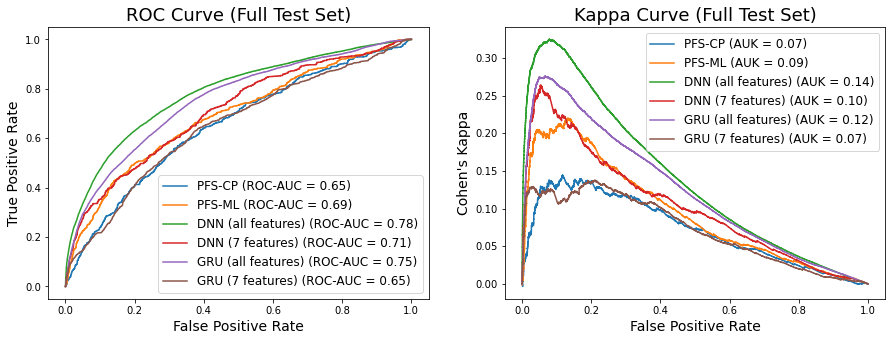

In [14]:
#Performance on the full test sets?
from sklearn.metrics import roc_curve

scores_opt_thres = [] #For storing the AUC, AUK and optimal thresholds of the kappa curve

#Create figures & set title, xlabel & ylabel
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title("ROC Curve (Full Test Set)", fontsize=18);
axes[0].set_xlabel('False Positive Rate', fontsize=14);
axes[0].set_ylabel('True Positive Rate', fontsize=14);
axes[1].set_title("Kappa Curve (Full Test Set)", fontsize=18);
axes[1].set_xlabel('False Positive Rate', fontsize=14);
axes[1].set_ylabel("Cohen's Kappa", fontsize=14);


for i, (model, modelname) in enumerate(zip(all_models, modelnames)):
    if (i==0):
        y_score = model.predict_proba(X_test[:, pfs_feats_indices])[:,1]
    elif (i==1):
        y_score = model.predict_proba(X_test[:, pfs_feats_indices])[:,1]
    elif (i==2):
        y_score = model.predict(X_test)
    elif (i==3):
        y_score = model.predict(X_test[:, pfs_feats_indices])
    elif (i==4):
        y_score_seq = model.predict(X_seq_test_padded)
        seq_lengths = [X_seq_test_pfs_feats[i].shape[0] for i in range(len(X_seq_test_pfs_feats))] #Prune the padding
        y_score = np.vstack([y_score_seq[i][:seq_lengths[i]] for i in range(y_score_seq.shape[0])]) #Flatten the labels again
    else:
        y_score_seq = model.predict(X_seq_test_padded_pfs_feats)
        seq_lengths = [X_seq_test_pfs_feats[i].shape[0] for i in range(len(X_seq_test_pfs_feats))] #Prune the padding
        y_score = np.vstack([y_score_seq[i][:seq_lengths[i]] for i in range(y_score_seq.shape[0])]) #Flatten the labels again

    #Retrieve kappa & auc
    auk = auk_score(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)
    
    #Add the predictions to df_test for later use in the case studies
    df_test['pred_'+modelname] = y_score

    #Plot the ROC & Kappa curves
    fpr, tpr, thres = roc_curve(y_test, y_score)
    _, kappas, _ = kappa_curve(y_test, y_score)
    print("Prediction stats of "+modelnames[i]+"\n\n",
          pd.Series(y_score.ravel()).describe(), '\n\n\n\n')
    axes[0].plot(fpr, tpr, label='{} (ROC-AUC = {:.2f})'.format(modelnames[i], auc))
    axes[1].plot(fpr, kappas, label='{} (AUK = {:.2f})'.format(modelnames[i], auk))

    #Find optimal threshold according to kappa curve and store auc, auk & threshold
    opt_thres = thres[kappas.argmax()]
    scores_opt_thres.append([auc, auk, opt_thres])

axes[0].legend(fontsize=12);
axes[1].legend(fontsize=12);

In [17]:
#Additionally: results on the full test set in a table
df_auc_auk_thres = pd.DataFrame(scores_opt_thres, columns=['ROC-AUC', 'AUK', 'Optimal Threshold'], index=modelnames)
df_auc_auk_thres

,ROC-AUC,AUK,Optimal Threshold
PFS-CP,0.652643,0.071005,0.107718
PFS-ML,0.690035,0.093686,0.812825
DNN (all features),0.783333,0.139086,0.842331
DNN (7 features),0.708702,0.102321,0.899563
GRU (all features),0.753656,0.122033,0.954768
GRU (7 features),0.649595,0.071237,0.915977


As we'd expect, the results on the test set are really close to the means of the bootstrapping procedure.

PFS-CP has notably low values for its predictions in general, and therefore has a very low threshold compared to the other modles (also see its descriptive statistics from the printed lines in the output above).

In [35]:
#Store the figure from above
# fig.savefig(os.path.join(figs_base_path, 'ROC-kappa-curves-full-test-set.jpg'),
#             dpi=200)

In [27]:
#Store df_test with the predictions for the case studies in another notebook
# df_test.to_hdf(path_or_buf=os.path.join(data_base_path, 'modeling_data', 'df_test_with_predictions.hdf'),
#                key='Processed_data',
#                mode='w',
#                complevel=9)

#Also store "optimal" thresholds from the kappa curve
# with open(os.path.join(data_base_path, 'modeling_data', 'optimal_thresholds_kappa_curve.json'), 'w') as f:
#     json.dump(df_auc_auk_thres['Optimal Threshold'].to_dict(), f, indent=4)